# Agentic Data Model Generation and Structured Output Powered by CAMEL & Qwen

You can also check this cookbook in colab [here](https://colab.research.google.com/drive/18E6W05FlykjqptWVMwCQGJoG2WyaY47A?usp=sharing)  (Use the colab share link)

<div class="align-center">
  <a href="https://www.camel-ai.org/"><img src="https://i.postimg.cc/KzQ5rfBC/button.png"width="150"></a>
  <a href="https://discord.camel-ai.org"><img src="https://i.postimg.cc/L4wPdG9N/join-2.png"  width="150"></a></a>
  
⭐ <i>Star us on [*Github*](https://github.com/camel-ai/camel), join our [*Discord*](https://discord.camel-ai.org) or follow our [*X*](https://x.com/camelaiorg)
</div>

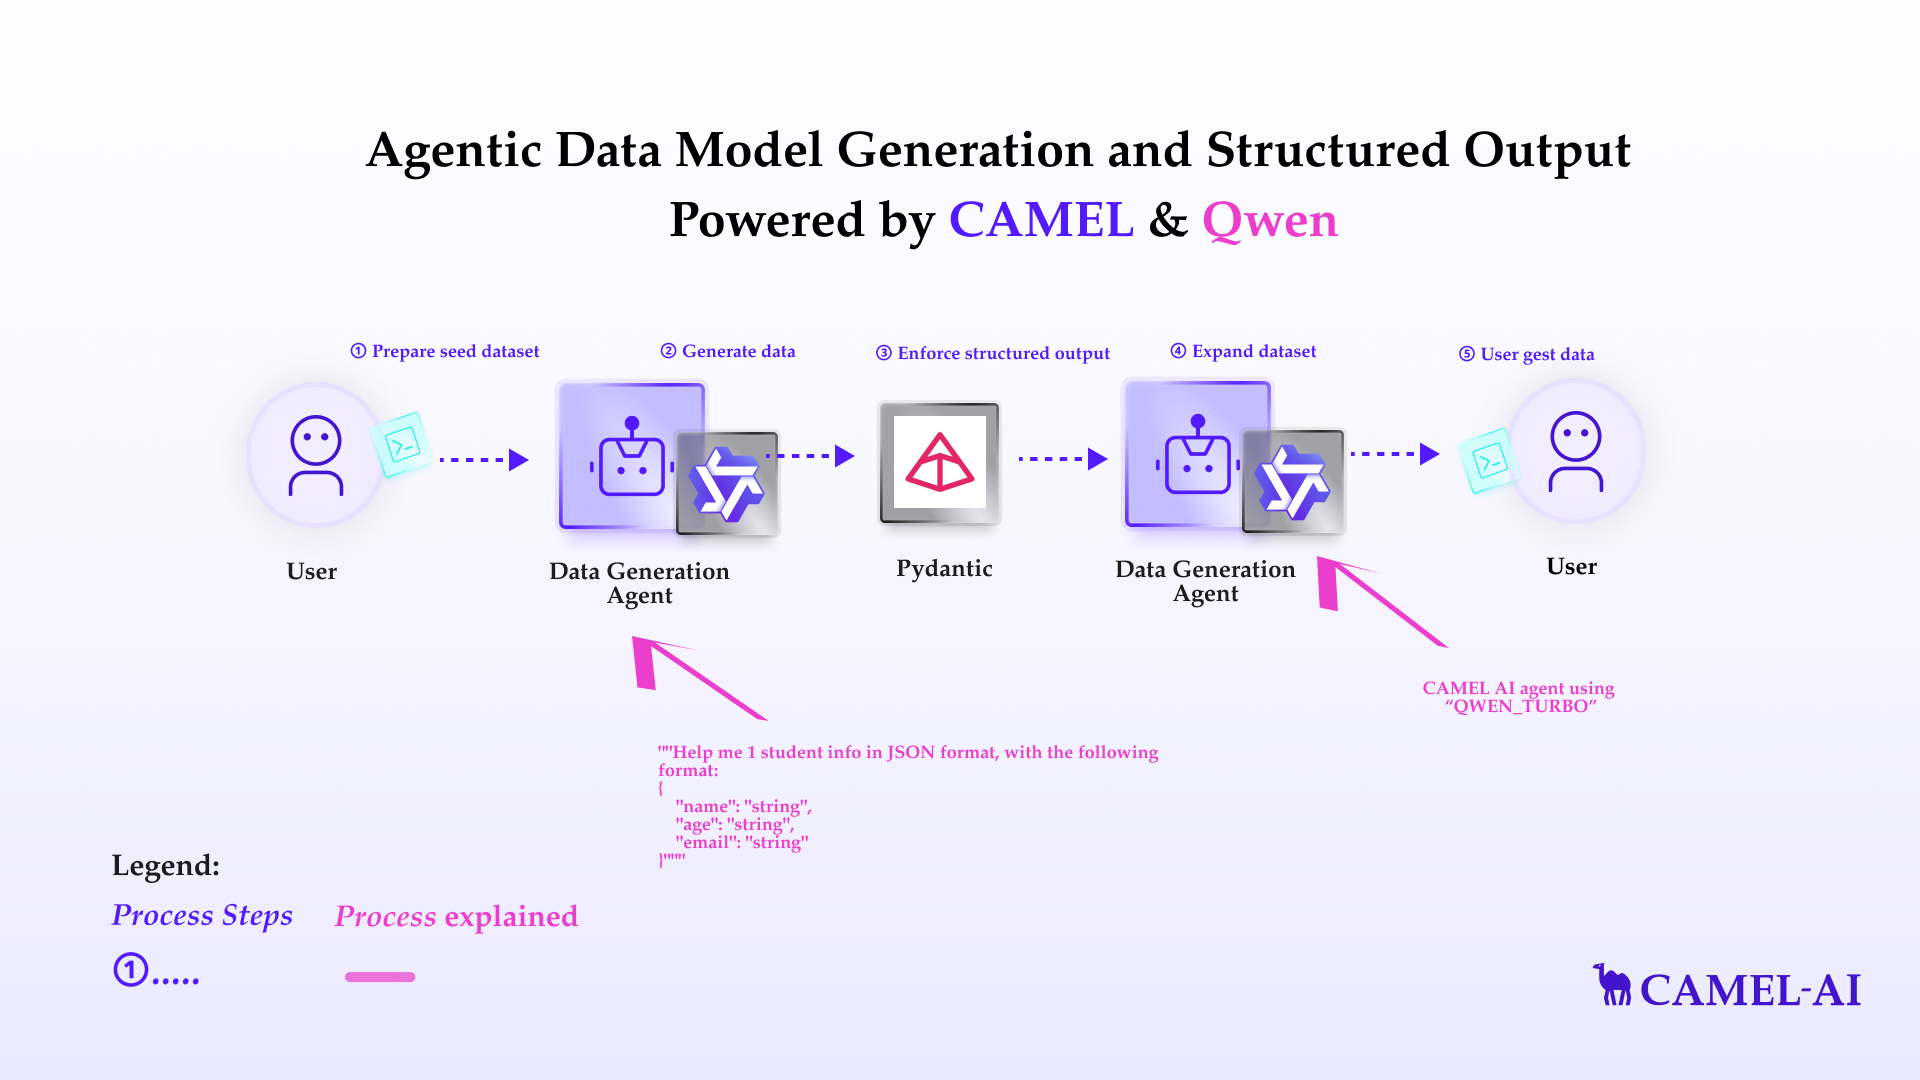

This notebook demonstrates how to set up and leverage CAMEL's ability of structure output, like JSON, and Pydantic objects.

In this notebook, you'll explore:

*   **CAMEL**: A powerful multi-agent framework that enables Retrieval-Augmented Generation and multi-agent role-playing scenarios, allowing for sophisticated AI-driven tasks.
*   **Structure output**: The ability of LLMs to return structured output.
*   **Qwen**: The Qwen model is a series of LLMs and multimodal models developed by the Qwen Team at Alibaba Group. Designed for diverse scenarios, Qwen integrates advanced AI capabilities, such as natural language understanding, text and vision processing, programming assistance, and dialogue simulation.

This setup not only demonstrates a practical application but also serves as a flexible framework that can be adapted for various scenarios requiring structure output and data generation.

## 📦 Installation

First, install the CAMEL package with all its dependencies:

In [ ]:
!pip install "camel-ai==0.2.16"

## 🔑 Setting Up API Keys

Your can go to [here](https://www.alibabacloud.com/help/en/model-studio/developer-reference/use-qwen-by-calling-api/) to get API Key from Qwen AI.

In [ ]:
# Prompt for the API key securely
import os
from getpass import getpass

qwen_api_key = getpass('Enter your API key: ')
os.environ["QWEN_API_KEY"] = qwen_api_key

Enter your API key: ··········


Alternatively, if running on Colab, you could save your API keys and tokens as **Colab Secrets**, and use them across notebooks.

To do so, **comment out** the above **manual** API key prompt code block(s), and **uncomment** the following codeblock.

⚠️ Don't forget granting access to the API key you would be using to the current notebook.

In [ ]:
# import os
# from google.colab import userdata

# os.environ["QWEN_API_KEY"] = userdata.get("QWEN_API_KEY")

## Qwen data generation

In this section, we'll demonstrate how to Qwen to generate structured data. [Qwen](https://www.alibabacloud.com/help/en/model-studio/developer-reference/use-qwen-by-calling-api) is a good example in Camel of using prompt engineering for structure output. It offers powerful models like **Qwen-max**, **Qwen-coder**, but yet not support structure output by itself. We can then make use of its own ability to generate structured data.

Import necessary libraries, define the Qwen agent, and define the Pydantic classes.

The following function retrieves relevant information from a list of URLs based on a given query. It combines web scraping with Firecrawl and CAMEL's AutoRetriever for a seamless information retrieval process. (Some explanation)

In [ ]:
from pydantic import BaseModel, Field

from camel.agents import ChatAgent
from camel.messages import BaseMessage
from camel.models import ModelFactory
from camel.types import ModelPlatformType, ModelType
from camel.configs import QwenConfig

In [ ]:
# Define Qwen model
qwen_model = ModelFactory.create(
    model_platform=ModelPlatformType.QWEN,
    model_type=ModelType.QWEN_CODER_TURBO,
    model_config_dict=QwenConfig().as_dict(),
)

qwen_agent = ChatAgent(
    model=qwen_model,
    message_window_size=10,
)


# Define Pydantic models
class Student(BaseModel):
    name: str
    age: str
    email: str

First, let's try if we don't specific format just in prompt.


In [ ]:
assistant_sys_msg = BaseMessage.make_assistant_message(
    role_name="Assistant",
    content="You are a helpful assistant in helping user to generate necessary data information.",
)

user_msg = """Help me 1 student info in JSON format, with the following format:
{
    "name": "string",
    "age": "string",
    "email": "string"
}"""

response = qwen_agent.step(user_msg)
print(response.msgs[0].content)

Sure! Here is an example of a student's information in JSON format:

```json
{
    "name": "John Doe",
    "age": "20",
    "email": "johndoe@example.com"
}
```

Feel free to replace the values with actual data for your specific use case!


It did it, but we need to expand our prompts, and the result still has some annoying extra texts, and we still need to parse it into valid JSON object by ourselves.

A more elegant way is to use the `response_format` argument in `.step()` function:

In [ ]:
qwen_agent.reset()
user_msg = "Help me 1 student info in JSON format"
response = qwen_agent.step(user_msg, response_format=Student)
print(response.msgs[0].content)

{
  "name": "John Doe",
  "age": "20",
  "email": "johndoe@example.com"
}


And we can directly extract the Pydantic object in `response.msgs[0].parsed` field:

In [ ]:
print(type(response.msgs[0].parsed))
print(response.msgs[0].parsed)


<class '__main__.Student'>
name='John Doe' age='20' email='johndoe@example.com'


Hooray, now we successfully generate 1 entry of student, suppose we want to generate more, we can still achieve this easily.

In [ ]:
class StudentList(BaseModel):
    studentList: list[Student]

user_msg = "Help me 5 random student info in JSON format"
response = qwen_agent.step(user_msg, response_format=StudentList)
print(response.msgs[0].content)
print(response.msgs[0].parsed)

{
  "studentList": [
    {
      "name": "Alice Johnson",
      "age": "22",
      "email": "alice.johnson@example.com"
    },
    {
      "name": "Bob Smith",
      "age": "21",
      "email": "bob.smith@example.com"
    },
    {
      "name": "Charlie Brown",
      "age": "23",
      "email": "charlie.brown@example.com"
    },
    {
      "name": "Diana Prince",
      "age": "24",
      "email": "diana.prince@example.com"
    },
    {
      "name": "Eve Adams",
      "age": "25",
      "email": "eve.adams@example.com"
    }
  ]
}
studentList=[Student(name='Alice Johnson', age='22', email='alice.johnson@example.com'), Student(name='Bob Smith', age='21', email='bob.smith@example.com'), Student(name='Charlie Brown', age='23', email='charlie.brown@example.com'), Student(name='Diana Prince', age='24', email='diana.prince@example.com'), Student(name='Eve Adams', age='25', email='eve.adams@example.com')]


That's it! We just generate 5 random students out of nowhere by using Qwen Camel agent!

## 🌟 Highlights

This notebook has guided you through setting up and running Qwen chat agent and use it to generate structured data.

Key tools utilized in this notebook include:

*   **CAMEL**: A powerful multi-agent framework that enables Retrieval-Augmented Generation and multi-agent role-playing scenarios, allowing for sophisticated AI-driven tasks.
*   **Qwen data generation**: Use Qwen model to generate structured data for further use of other applications.


That's everything: Got questions about 🐫 CAMEL-AI? Join us on [Discord](https://discord.camel-ai.org)! Whether you want to share feedback, explore the latest in multi-agent systems, get support, or connect with others on exciting projects, we’d love to have you in the community! 🤝

Check out some of our other work:

1. 🐫 Creating Your First CAMEL Agent [free Colab](https://docs.camel-ai.org/cookbooks/create_your_first_agent.html)

2.  Graph RAG Cookbook [free Colab](https://colab.research.google.com/drive/1uZKQSuu0qW6ukkuSv9TukLB9bVaS1H0U?usp=sharing)

3. 🧑‍⚖️ Create A Hackathon Judge Committee with Workforce [free Colab](https://colab.research.google.com/drive/18ajYUMfwDx3WyrjHow3EvUMpKQDcrLtr?usp=sharing)

4. 🔥 3 ways to ingest data from websites with Firecrawl & CAMEL [free Colab](https://colab.research.google.com/drive/1lOmM3VmgR1hLwDKdeLGFve_75RFW0R9I?usp=sharing)

5. 🦥 Agentic SFT Data Generation with CAMEL and Mistral Models, Fine-Tuned with Unsloth [free Colab](https://colab.research.google.com/drive/1lYgArBw7ARVPSpdwgKLYnp_NEXiNDOd-?usp=sharingg)

Thanks from everyone at 🐫 CAMEL-AI


<div class="align-center">
  <a href="https://www.camel-ai.org/"><img src="https://i.postimg.cc/KzQ5rfBC/button.png"width="150"></a>
  <a href="https://discord.camel-ai.org"><img src="https://i.postimg.cc/L4wPdG9N/join-2.png"  width="150"></a></a>
  
⭐ <i>Star us on [*Github*](https://github.com/camel-ai/camel), join our [*Discord*](https://discord.camel-ai.org) or follow our [*X*](https://x.com/camelaiorg)
</div>